Paytm lacks an automated way to measure the effectiveness of its in-stadium advertisements and evaluate how well the camera angles used by ICC capture its logo. Manually analyzing hours of video footage is impractical and error-prone. To address this, Paytm requires a data-driven approach to analyze video streams, detect the Paytm logo, and quantify its visibility. This will enable Paytm to evaluate the impact of its advertisements  for television viewers .

In [ ]:
'''import cv2
import os

def extract_frames(video_path, output_folder):
    """
    Extracts frames from a video and saves them as JPG images every second.
    
    :param video_path: Path to the input video file
    :param output_folder: Folder to save extracted frames
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Get frames per second
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames // fps  # Get video duration in seconds
    expected_frames = duration  # Number of frames expected (1 per second)
    frame_interval = fps  # Capture one frame per second
    
    success, image = cap.read()
    count = 0
    frame_count = 0
    
    while success:
        if count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, image)
            frame_count += 1
            print(f"Saved {frame_filename} ({frame_count}/{expected_frames})")
        
        success, image = cap.read()
        count += 1
    
    cap.release()
    print(f"Extracted {frame_count} frames (expected {expected_frames}) and saved to {output_folder}")

# Example usage
video_file = "/Users/rohaniyer/VS code/videoplayback (1).mp4"  # Change this to your video file path
output_directory = "/Users/rohaniyer/VS code/frames/"  # Directory to save frames
extract_frames(video_file, output_directory)



'''

In [2]:
pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Installing necessary libraries

In [3]:
# Install ultralytics (YOLOv8)
!pip install ultralytics --quiet
!pip install opencv-python --quiet

import os
import cv2
import torch
from ultralytics import YOLO



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


extracting zip file

In [4]:
import zipfile
import os

zip_path = "/Users/rohaniyer/Downloads/mock5/dataset_final.zip"  # Change this to your actual file path
extract_to = "/Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [5]:
import os
import shutil

# Define original dataset path (Read-Only or Original)
original_dataset_path = "/Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset" #ensure this is the correct path

# Define new dataset path (Writable)
writable_dataset_path = "/Users/rohaniyer/Downloads/mock5/dataset-final/dataset"

try:
    # Create parent directories if they don't exist.
    os.makedirs(os.path.dirname(writable_dataset_path), exist_ok=True)

    # Copy dataset from input to working directory
    shutil.copytree(original_dataset_path, writable_dataset_path)

    print("Dataset copied successfully!")

except OSError as e:
    print(f"Error copying dataset: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error copying dataset: [Errno 17] File exists: '/Users/rohaniyer/Downloads/mock5/dataset-final/dataset'


In [6]:
import random

# Define paths
image_dir = os.path.join(writable_dataset_path, "images")
label_dir = os.path.join(writable_dataset_path, "labels")

# Create train, val, test directories
splits = ["train", "val", "test"]
for split in splits:
    os.makedirs(os.path.join(writable_dataset_path, f"images/{split}"), exist_ok=True)
    os.makedirs(os.path.join(writable_dataset_path, f"labels/{split}"), exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Shuffle and split (70% train, 20% val, 10% test)
random.shuffle(image_files)
total_images = len(image_files)

train_split = int(0.7 * total_images)
val_split = int(0.9 * total_images)  # 70% train + 20% val = 90%, rest 10% is test

train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

# Function to move files
def move_files(file_list, split):
    for img_file in file_list:
        shutil.move(os.path.join(image_dir, img_file), os.path.join(writable_dataset_path, f"images/{split}", img_file))
        label_file = img_file.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(label_dir, label_file)):
            shutil.move(os.path.join(label_dir, label_file), os.path.join(writable_dataset_path, f"labels/{split}", label_file))

# Move files to respective folders
move_files(train_files, "train")
move_files(val_files, "val")
move_files(test_files, "test")

print(f"Data split completed: {len(train_files)} training, {len(val_files)} validation, {len(test_files)} testing images.")


Data split completed: 0 training, 0 validation, 0 testing images.


TRAIN , VALIDATION , TEST split

In [9]:
import os
import shutil
import random
from glob import glob

# Define paths
dataset_path = "/Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset/dataset"
image_path = os.path.join(dataset_path, "images")
label_path = os.path.join(dataset_path, "labels")

# Output directories for YOLO format (CHANGE THIS TO A LOCAL PATH)
output_dir = "/Users/rohaniyer/Downloads/mock5/paytm-dataset"  # Change this to your desired local output path

splits = ["train", "val", "test"]

for split in splits:
    os.makedirs(os.path.join(output_dir, f"images/{split}"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, f"labels/{split}"), exist_ok=True)

# Get all images and shuffle them
all_images = glob(os.path.join(image_path, "*.jpg"))
random.shuffle(all_images)

# Split dataset (e.g., 70% train, 20% val, 10% test)
train_split = int(0.7 * len(all_images))
val_split = int(0.9 * len(all_images))  # 20% validation, 10% test

train_images = all_images[:train_split]
val_images = all_images[train_split:val_split]
test_images = all_images[val_split:]

# Function to move images and labels
def move_files(images, split):
    for img in images:
        img_filename = os.path.basename(img)
        label_filename = img_filename.replace(".jpg", ".txt")

        # Move image
        shutil.copy(img, os.path.join(output_dir, f"images/{split}/{img_filename}"))

        # Move corresponding label file (if exists)
        label_file = os.path.join(label_path, label_filename)
        if os.path.exists(label_file):
            shutil.copy(label_file, os.path.join(output_dir, f"labels/{split}/{label_filename}"))

# Move files to respective folders
move_files(train_images, "train")
move_files(val_images, "val")
move_files(test_images, "test")

print("Dataset successfully converted to YOLO format and split into train, val, and test!")

Dataset successfully converted to YOLO format and split into train, val, and test!


The bounding box annotations are used during training, and their role is:

The move_files() function ensures that both images and their corresponding .txt label files are copied into images/train, labels/train, etc.
The dataset.yaml file defines the dataset path so YOLO can automatically load the bounding boxes for training.
When YOLOv8 reads the dataset.yaml, it looks for the images and their corresponding labels in the labels/ folder.

In [10]:
import os

dataset_yaml = """
path: /Users/rohaniyer/Downloads/mock5/paytm-dataset  # Change this to the actual path you used
train: images/train
val: images/val
test: images/test

names:
  0: paytm_logo
"""

# Save the file (CHANGE THIS TO YOUR LOCAL PATH)
local_path = "/Users/rohaniyer/Downloads/mock5/paytm-dataset/dataset.yaml" # change this

# Create the parent directory if it doesn't exist.
os.makedirs(os.path.dirname(local_path), exist_ok=True)

with open(local_path, "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml file created!")

dataset.yaml file created!


In [11]:
from ultralytics import YOLO
import torch

# Load YOLO model
model = YOLO("yolov8s.pt")

# Check if CUDA is available
if torch.cuda.is_available():
    # Train YOLO on Paytm dataset (GPU)
    model.train(data="/Users/rohaniyer/Downloads/mock5/paytm-dataset/dataset.yaml", epochs=50, imgsz=640, batch=8, device=0)
else:
    print("CUDA is not available. Training on CPU.")
    model.train(data="/Users/rohaniyer/Downloads/mock5/paytm-dataset/dataset.yaml", epochs=50, imgsz=640, batch=8, device="cpu")

CUDA is not available. Training on CPU.
New https://pypi.org/project/ultralytics/8.3.91 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.87 🚀 Python-3.9.6 torch-2.6.0 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/rohaniyer/Downloads/mock5/paytm-dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, r

train: Scanning /Users/rohaniyer/Downloads/mock5/paytm-dataset/labels/train... 129 images, 16 backgrounds, 58 corrupt: 100%|██████████| 129/129 [00:00<00:00, 2236.44it/s]

train: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/train/frame_1000_jpg.rf.7c8d86d7f9a7e0ce032caddaf44cfdf5.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/train/frame_10100_jpg.rf.3662a1aaf10c96bc6add47e7e1e57195.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/train/frame_1010_jpg.rf.c223ccdeefdcbd1df1e0a07fd184a2b3.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/train/frame_1020_jpg.rf.56201e1e8ae887471c6b10d55ab7d5c2.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /Users/rohaniyer/Download


/Users/rohaniyer/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/rohaniyer/Downloads/mock5/paytm-dataset/labels/val... 61 images, 6 backgrounds, 28 corrupt: 100%|██████████| 61/61 [00:00<00:00, 3404.42it/s]

val: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/val/frame_1000_jpg.rf.7c8d86d7f9a7e0ce032caddaf44cfdf5.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/val/frame_10100_jpg.rf.3662a1aaf10c96bc6add47e7e1e57195.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/val/frame_1010_jpg.rf.c223ccdeefdcbd1df1e0a07fd184a2b3.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/val/frame_10340_jpg.rf.0737a3f62fe27b7753ea087bc9116116.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /Users/rohaniyer/Downloads/mock5/paytm-dat

Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.683      9.934      1.797         10        640: 100%|██████████| 9/9 [00:32<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.16s/it]

                   all         33         41      0.231     0.0976     0.0842     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.109       4.38      1.424         19        640: 100%|██████████| 9/9 [00:31<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.67s/it]

                   all         33         41     0.0663      0.537     0.0501     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.163      3.678      1.453         13        640: 100%|██████████| 9/9 [00:31<00:00,  3.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]

                   all         33         41      0.282      0.431      0.281      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.064      2.947      1.471         12        640: 100%|██████████| 9/9 [00:31<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]

                   all         33         41       0.44      0.463       0.44       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.081      2.878      1.428         18        640: 100%|██████████| 9/9 [00:31<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41     0.0389      0.463     0.0333     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.987      2.618      1.394         14        640: 100%|██████████| 9/9 [00:30<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.292      0.268      0.135      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.884      2.283      1.323         23        640: 100%|██████████| 9/9 [00:30<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.408       0.39      0.273      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.009      2.466      1.389         14        640: 100%|██████████| 9/9 [00:30<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.348      0.509      0.274      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.849      2.179      1.344         33        640: 100%|██████████| 9/9 [00:32<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]

                   all         33         41      0.635      0.463      0.425      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.802      2.085      1.356         16        640: 100%|██████████| 9/9 [00:31<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.621      0.415      0.399      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.869       2.28      1.375          8        640: 100%|██████████| 9/9 [00:31<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.342      0.439      0.264      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G       1.91      2.025      1.377         15        640: 100%|██████████| 9/9 [00:31<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.405      0.512      0.482      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.968      2.323       1.45         24        640: 100%|██████████| 9/9 [00:31<00:00,  3.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.459      0.496      0.497      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.976      2.173      1.396         23        640: 100%|██████████| 9/9 [00:31<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.559      0.341      0.434      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.936      2.173       1.48         12        640: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]

                   all         33         41      0.549      0.561      0.556      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.711      1.855      1.234         12        640: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.627      0.561      0.578      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.839      1.959      1.282         14        640: 100%|██████████| 9/9 [00:27<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]

                   all         33         41      0.539      0.537      0.542      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.744      2.162      1.361          8        640: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.699      0.453      0.583      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.728      1.814      1.303         26        640: 100%|██████████| 9/9 [00:30<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.797      0.561      0.684      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.717      1.872       1.34         19        640: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.689       0.61      0.599      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.625      1.686      1.275         29        640: 100%|██████████| 9/9 [00:30<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.708      0.651      0.597      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.546      1.681      1.297          8        640: 100%|██████████| 9/9 [00:30<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.904      0.585      0.733      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.704      1.626      1.374          9        640: 100%|██████████| 9/9 [00:30<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.714      0.659      0.753      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.587      1.717       1.32         13        640: 100%|██████████| 9/9 [00:31<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]

                   all         33         41      0.809      0.622      0.761      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.641      1.644      1.249         11        640: 100%|██████████| 9/9 [00:30<00:00,  3.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]

                   all         33         41      0.794      0.707      0.808      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.713      1.557       1.36         13        640: 100%|██████████| 9/9 [00:30<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]

                   all         33         41       0.72      0.683       0.75      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.615      1.616      1.345         15        640: 100%|██████████| 9/9 [00:31<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.68s/it]

                   all         33         41      0.562      0.707      0.702      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/50         0G      1.554       1.56       1.23         16        640: 100%|██████████| 9/9 [00:30<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.779      0.634       0.77      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.494      1.493      1.237         14        640: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.717      0.681      0.728      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.582      1.655      1.259          8        640: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]

                   all         33         41      0.757      0.707      0.732      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.545      1.497      1.222         10        640: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.661      0.707      0.764      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.458      1.271      1.125          8        640: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41       0.75      0.733        0.8      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.552      1.419      1.251         16        640: 100%|██████████| 9/9 [00:30<00:00,  3.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.758      0.765       0.81      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.594      1.543      1.323         26        640: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.761       0.78      0.814      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.584      1.431      1.337         28        640: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.777      0.707      0.767      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.415      1.373      1.245         17        640: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.709      0.732      0.766      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.489      1.384      1.169          5        640: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.761      0.659      0.765      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.387      1.266      1.126         14        640: 100%|██████████| 9/9 [00:27<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41       0.84      0.683      0.804      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.537      1.367      1.224         18        640: 100%|██████████| 9/9 [00:27<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]

                   all         33         41      0.884      0.634      0.803      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.433      1.318      1.168         10        640: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.67s/it]

                   all         33         41      0.703      0.732      0.808      0.513


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.362      1.322      1.215          9        640: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.717      0.742      0.805      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.322      1.432      1.183         13        640: 100%|██████████| 9/9 [00:28<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.762      0.707      0.815      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.236      1.266      1.177          9        640: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41       0.69       0.78       0.79      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.315      1.317      1.239          6        640: 100%|██████████| 9/9 [00:29<00:00,  3.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.697      0.756      0.787      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.268      1.237      1.162         15        640: 100%|██████████| 9/9 [00:27<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.728       0.78      0.811       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.271      1.274      1.188          9        640: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.64s/it]

                   all         33         41      0.734      0.807      0.827      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.198      1.177      1.127          7        640: 100%|██████████| 9/9 [00:30<00:00,  3.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.704      0.829      0.821      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.298      1.296      1.208          2        640: 100%|██████████| 9/9 [00:30<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.711      0.829       0.83      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G       1.23      1.093      1.188          7        640: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

                   all         33         41      0.741      0.829      0.843       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G       1.23      1.196      1.126          8        640: 100%|██████████| 9/9 [00:30<00:00,  3.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.66s/it]

                   all         33         41      0.748      0.829       0.85      0.565



50 epochs completed in 0.530 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.87 🚀 Python-3.9.6 torch-2.6.0 CPU (Apple M3 Pro)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.58s/it]


                   all         33         41      0.749      0.829       0.85      0.569
Speed: 0.6ms preprocess, 232.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train4


In [45]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Load trained YOLOv8 model
model = YOLO('/Users/rohaniyer/Downloads/mock5/runs/detect/train4/weights/best.pt')

# Define training image directory
train_image_dir = "/Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset/dataset/images"
train_images = os.listdir(train_image_dir)

# Select a few images for visualization
num_images_to_show = min(5, len(train_images))  # Show up to 5 images
selected_images = train_images[:num_images_to_show]

# Run inference and visualize
for img_name in selected_images:
    img_path = os.path.join(train_image_dir, img_name)
    
    # Run inference
    results = model(img_path)
    
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

    # Draw bounding boxes on image
    for box in results[0].boxes:
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Bounding box coordinates
        confidence = box.conf[0].item()  # Confidence score
        class_id = int(box.cls[0].item())  # Class ID
        
        # Draw rectangle
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        label = f"Paytm ({confidence:.2f})"
        cv2.putText(img, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Training Detection: {img_name}")
    plt.show()



image 1/1 /Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset/dataset/images/frame_1680_jpg.rf.0c2411855a7d1992652a46cea8eecee3.jpg: 640x640 (no detections), 102.0ms
Speed: 1.5ms preprocess, 102.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


<Figure size 600x600 with 1 Axes>


image 1/1 /Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset/dataset/images/frame_20620_jpg.rf.f2d52bd2ca1463f7d4e7991a615ecbe8.jpg: 640x640 (no detections), 105.0ms
Speed: 0.6ms preprocess, 105.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


<Figure size 600x600 with 1 Axes>


image 1/1 /Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset/dataset/images/frame_12010_jpg.rf.fa81f530e1f001502de6cfa0ad818ca8.jpg: 640x640 1 paytm_logo, 79.3ms
Speed: 0.6ms preprocess, 79.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


<Figure size 600x600 with 1 Axes>


image 1/1 /Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset/dataset/images/frame_2560.jpg: 384x640 2 paytm_logos, 51.7ms
Speed: 0.6ms preprocess, 51.7ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)


<Figure size 600x600 with 1 Axes>


image 1/1 /Users/rohaniyer/Downloads/mock5/Paytm_LOGO_Dataset/dataset/images/frame_16500_jpg.rf.56554b6747cac41f713aa329ed5751a3.jpg: 640x640 (no detections), 74.6ms
Speed: 0.6ms preprocess, 74.6ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


<Figure size 600x600 with 1 Axes>

Visualisations for different losses and other metrics

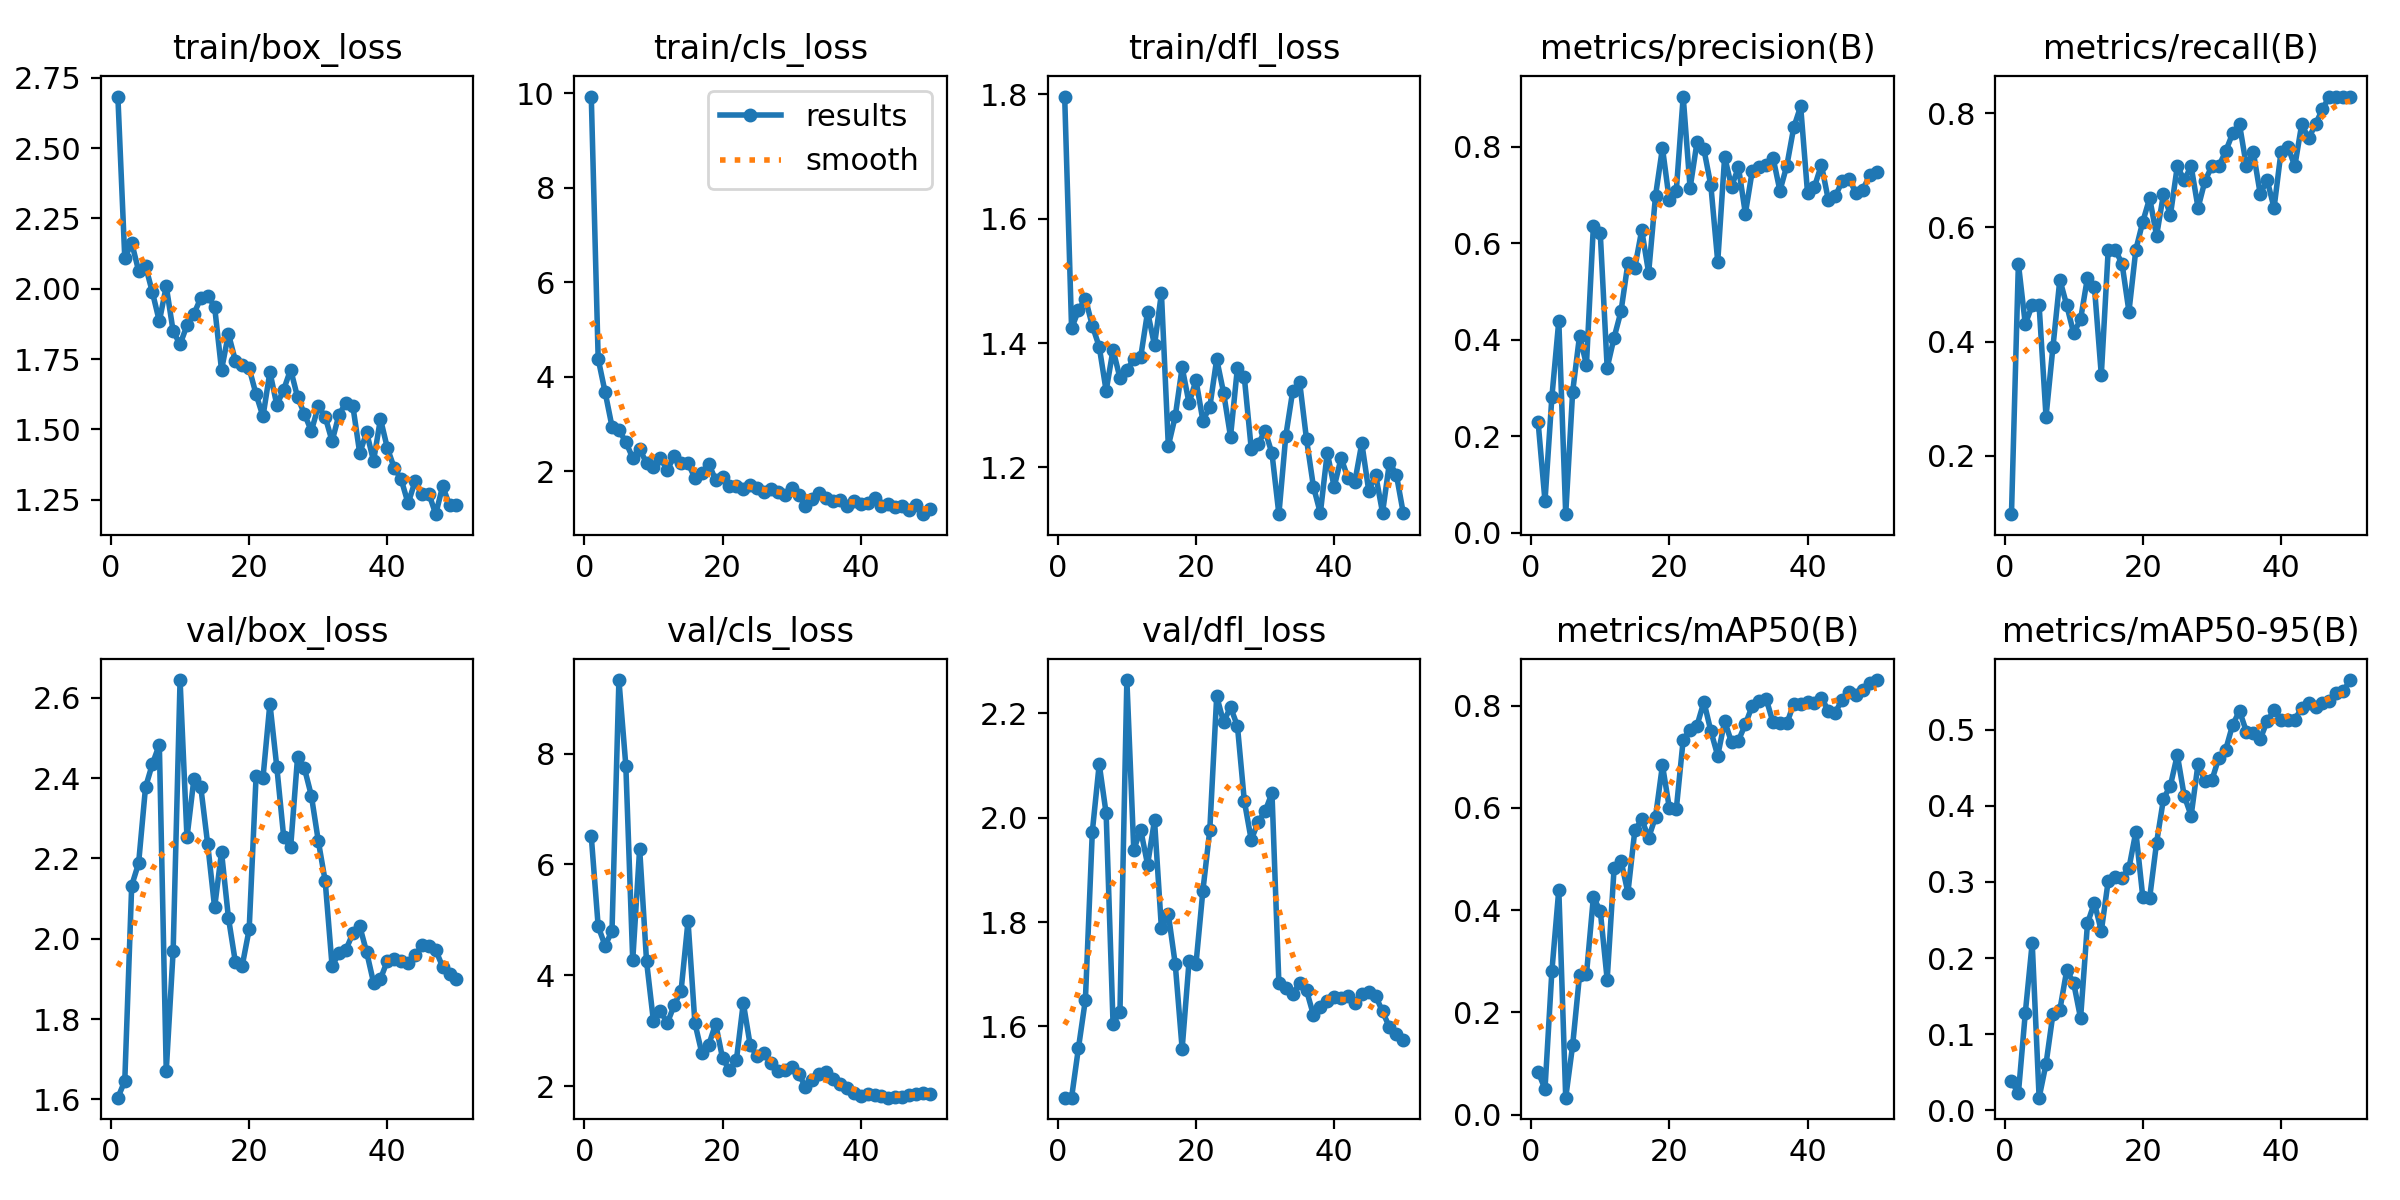

In [46]:
from IPython.display import display, Image
import os

# Assuming your training results are in a 'runs' directory, adjust the path accordingly.
# Replace 'your_training_run_directory' with the actual path to your training results.
training_run_directory = '/Users/rohaniyer/Downloads/mock5/runs/detect/train4' #replace with your path

results_png_path = os.path.join(training_run_directory, 'results.png')

# Check if the file exists before attempting to display it.
if os.path.exists(results_png_path):
    display(Image(filename=results_png_path))
else:
    print(f"Error: results.png not found at {results_png_path}")

In [85]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import random

# Load trained model (Make sure to replace with the correct trained model path)
model = YOLO('/Users/rohaniyer/Downloads/mock5/runs/detect/train4/weights/best.pt')

# Define test image path
test_image_dir = "/Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/paytm"
test_images = os.listdir(test_image_dir)

# Select a random test image
sample_image = random.choice(test_images)
sample_image_path = os.path.join(test_image_dir, sample_image)

# Run inference
results = model(sample_image_path)

# Convert image to display format
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot original image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Original Test Image")
plt.show()

# Show YOLOv8 predictions
results[0].show()



image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/paytm/paytmtest2.jpg: 384x640 (no detections), 102.6ms
Speed: 1.3ms preprocess, 102.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


<Figure size 800x800 with 1 Axes>

In [83]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import random

# Load trained model (Make sure to replace with the correct trained model path)
model = YOLO('/Users/rohaniyer/Downloads/mock5/runs/detect/train4/weights/best.pt')

# Define test image path
test_image_dir = "/Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test"
test_images = os.listdir(test_image_dir)

# Select a random test image
sample_image = random.choice(test_images)
sample_image_path = "/Users/rohaniyer/Downloads/mock5/paytmtest2.jpg"

# Run inference
results = model(sample_image_path)

# Convert image to display format
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot original image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Original Test Image")
plt.show()

# Show YOLOv8 predictions
results[0].show()



image 1/1 /Users/rohaniyer/Downloads/mock5/paytmtest2.jpg: 384x640 (no detections), 110.7ms
Speed: 2.6ms preprocess, 110.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


<Figure size 800x800 with 1 Axes>

In [84]:
results = model("/Users/rohaniyer/Downloads/mock5/paytmtest3.jpg")
print(results[0].show())


image 1/1 /Users/rohaniyer/Downloads/mock5/paytmtest3.jpg: 448x640 (no detections), 164.1ms
Speed: 4.0ms preprocess, 164.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
None



image 1/122 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_1000.jpg: 384x640 2 paytm_logos, 53.3ms
image 2/122 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_10000_jpg.rf.73c4306cb1a3bf65fe17d7f7c3b842b3.jpg: 640x640 9 paytm_logos, 82.8ms
image 3/122 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_1000_jpg.rf.7c8d86d7f9a7e0ce032caddaf44cfdf5.jpg: 640x640 1 paytm_logo, 91.3ms
image 4/122 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_10050_jpg.rf.60dbba81a98635122b4574f762c194a6.jpg: 640x640 (no detections), 84.9ms
image 5/122 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_10070_jpg.rf.7fef6a55cb63fe78524c46d0a2413a07.jpg: 640x640 (no detections), 88.4ms
image 6/122 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_10080_jpg.rf.390a844e045b64e9e4e752cd09a39a5a.jpg: 640x640 (no detections), 81.5ms
image 7/122 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_10090_jpg.r

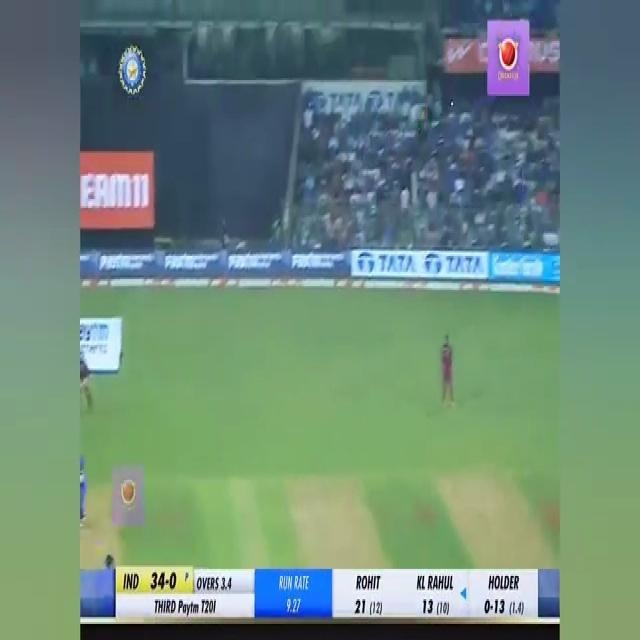

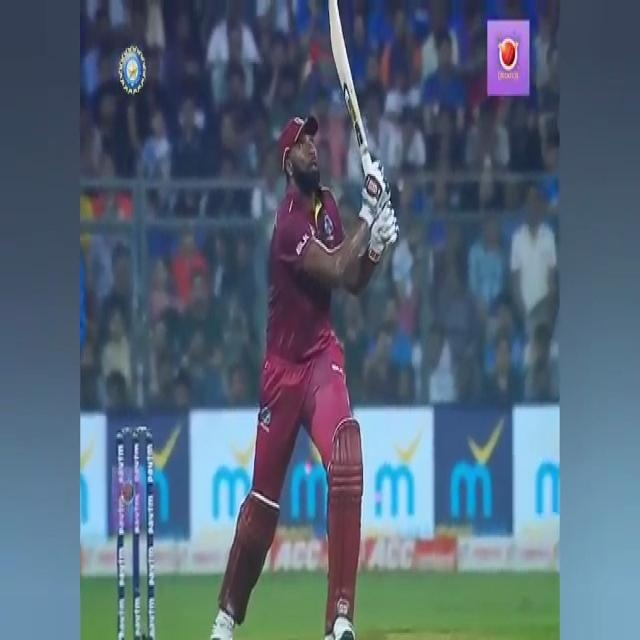

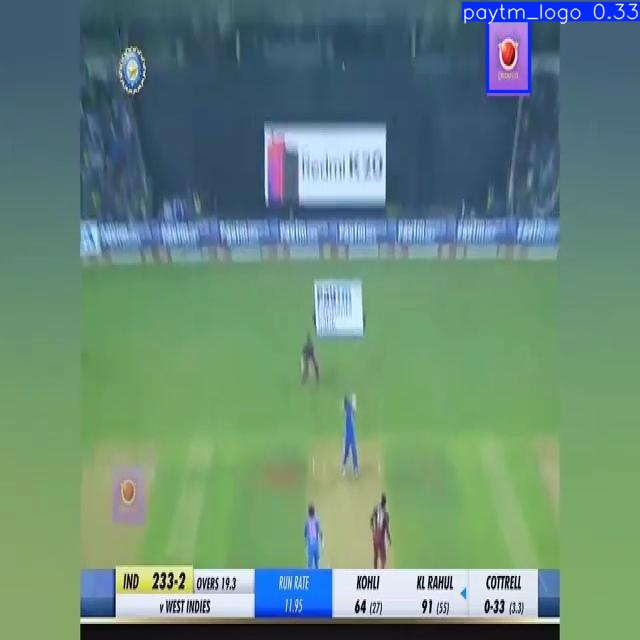

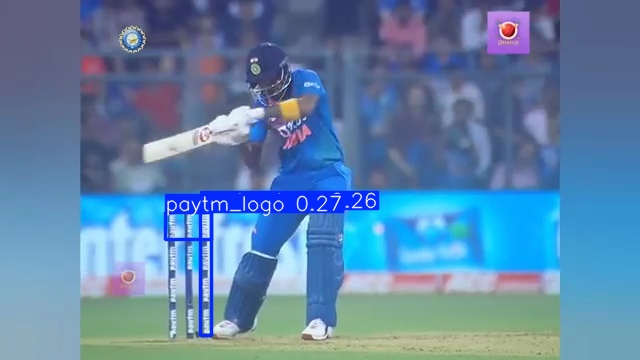

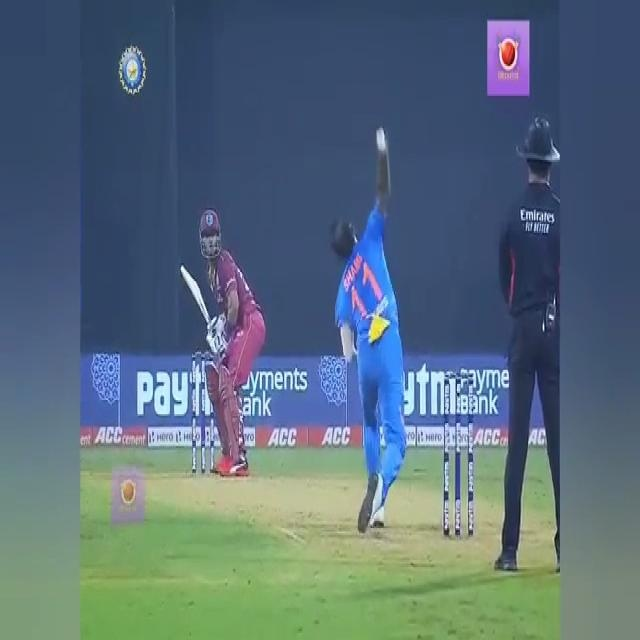

In [17]:
# Run inference on all test images
results = model(test_image_dir, save=True)

# Display processed images
output_dir = "/Users/rohaniyer/Downloads/mock5/runs/detect/predict5"  # YOLO saves predictions here
predicted_images = os.listdir(output_dir)

for img_file in predicted_images[:5]:  # Show first 5 predictions
    img_path = os.path.join(output_dir, img_file)
    display(Image(filename=img_path))


######

In [48]:
!pip install dash
!pip install dash-html-components
!pip install dash-core-components
!pip install ngrok

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [49]:
!pip install jupyter-dash

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [50]:
!pip install pyngrok

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [54]:
import os
os.system("fuser -k 8051/tcp")  # Replace 8051 with your port number


fuser: [-cfu] file ...
	-c	file is treated as mount point
	-f	the report is only for the named files
	-u	print username of pid in parenthesis


Unknown option: k


256

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import cv2
import os
from ultralytics import YOLO
import base64
import flask
import subprocess
from pyngrok import ngrok, conf

# --- Kill any previous Dash instance running on the same port ---
subprocess.run(["fuser", "-k", "8051/tcp"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# --- Initialize Flask & Dash ---
server = flask.Flask(__name__)  # Ensures a fresh server instance
app = dash.Dash(__name__, server=server, external_stylesheets=['https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css'])

# --- Model Configuration ---
model_path = "/Users/rohaniyer/Downloads/mock5/runs/detect/train4/weights/best.pt"
image_dir = "/Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test"
confidence_thresholds = {"visible": 0.7, "partially_visible": 0.4}

# --- Load YOLO Model ---
model = YOLO(model_path)

# --- Fetch Test Images ---
test_images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# --- Convert Paytm Logo to Base64 ---
paytm_logo_path = "/Users/rohaniyer/Downloads/mock5/Paytm-Logo.png"

def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

paytm_logo_base64 = encode_image(paytm_logo_path)
paytm_logo_url = f"data:image/png;base64,{paytm_logo_base64}"

# --- Function to classify visibility ---
def classify_visibility(image_path, model, confidence_thresholds):
    results = model(image_path)
    if not results[0].boxes:
        return "Not Visible", 0.0
    max_confidence = max(box.conf[0].item() for box in results[0].boxes)
    if max_confidence >= confidence_thresholds["visible"]:
        return "Visible", max_confidence
    elif max_confidence >= confidence_thresholds["partially_visible"]:
        return "Partially Visible", max_confidence
    else:
        return "Not Visible", max_confidence

# --- Dash Layout ---
app.layout = html.Div(
    style={"backgroundColor": "#ffffff", "minHeight": "100vh", "padding": "20px"},
    children=[
        html.Div(className="text-center", children=[
            html.Img(src=paytm_logo_url, style={"width": "200px", "marginBottom": "20px"}),
        ]),
        
        html.Div(className="card shadow p-4", style={"backgroundColor": "#1e1e1e", "color": "#ffffff"}, children=[
            dcc.Dropdown(
                id='image-dropdown',
                options=[{'label': image, 'value': image} for image in test_images],
                value=test_images[0] if test_images else None,
                placeholder="Select an image",
                className="form-select"
            ),
        ]),

        html.Div(className="card shadow mt-4 p-4", style={"backgroundColor": "#1e1e1e", "color": "#ffffff"}, children=[
            html.Div(className="text-center", children=[
                html.Img(id='image-output', src='', className="img-fluid rounded border"),
            ]),
            html.Div(id='classification-output', className="text-center mt-3 fw-bold fs-4"),
            html.Div(id='confidence-output', className="text-center mt-2 fs-5 text-secondary"),
        ]),
    ]
)

# --- Callback to Process Image ---
@app.callback(
    [Output('image-output', 'src'), Output('classification-output', 'children'), Output('confidence-output', 'children')],
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    if selected_image:
        image_path = os.path.join(image_dir, selected_image)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        results = model(image_path)
        visibility, confidence = classify_visibility(image_path, model, confidence_thresholds)
        
        # Draw bounding boxes
        for box in results[0].boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            label = f"Paytm ({conf:.2f})"
            cv2.putText(image_rgb, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        _, encoded_image = cv2.imencode('.jpg', image_rgb)
        image_base64 = base64.b64encode(encoded_image).decode('utf-8')
        image_src = f"data:image/jpeg;base64,{image_base64}"
        
        visibility_class = "text-success" if visibility == "Visible" else "text-warning" if visibility == "Partially Visible" else "text-danger"
        
        return image_src, html.Span(f"Visibility: {visibility}", className=visibility_class), f"Confidence: {confidence:.2f}"
    else:
        return '', '', ''

# --- Run the App ---
if __name__ == '__main__':
    # --- OPTIONAL: Ngrok Tunnel Setup ---
    enable_ngrok = False  # Set to True if you want ngrok

    if enable_ngrok:
        NGROK_AUTHTOKEN = "2uRsGkjGmllp25iusp2lUQqHLoT_4nJv5s8KZ6BM1RYURvmMD"  # Replace with your authtoken
        pyngrok_config = conf.get_default()
        ngrok.set_auth_token(NGROK_AUTHTOKEN, pyngrok_config=pyngrok_config)
        ngrok.kill()
        public_url = ngrok.connect(8080, pyngrok_config=pyngrok_config)
        print(f" * ngrok tunnel available at: {public_url}")

    # --- Start Dash App ---
    app.run_server(debug=True, port=8080, host="0.0.0.0")



image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_1680_jpg.rf.0c2411855a7d1992652a46cea8eecee3.jpg: 640x640 (no detections), 107.7ms
Speed: 2.6ms preprocess, 107.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_1680_jpg.rf.0c2411855a7d1992652a46cea8eecee3.jpg: 640x640 (no detections), 95.7ms
Speed: 1.1ms preprocess, 95.7ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)


t=2025-03-17T21:07:11+0530 lvl=warn msg="failed to check for update" obj=updater err="Post \"https://update.equinox.io/check\": context deadline exceeded"
t=2025-03-18T11:19:51+0530 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=36b3ca949e8b err="read tcp 192.168.9.216:56826->3.133.228.214:443: read: operation timed out"
t=2025-03-18T11:19:55+0530 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=f6440a56cd1d clientid=187dd8e0b1fa24359eec787d905e66b3
t=2025-03-18T11:55:33+0530 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=36b3ca949e8b err="read tcp 192.168.9.216:57796->3.20.27.198:443: read: operation timed out"
t=2025-03-18T11:55:35+0530 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=6172b06dc18a clientid=187dd8e0b1fa24359eec787d905e66b3
t=2025-03-18T12:11:50+0530 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnel

In [39]:
!pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 7.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 14.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [60]:
!pip install cohere

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 238.1 kB/s eta 0:00:00a 0:00:02
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.20
    Uninstalling urllib3-1.26.20:
      Successfully uninstalled urllib3-1.26.20
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.35.99 requires urllib3<1.27,>=1.25.4; python_version < "3.10", but you have urllib3 2.3.0 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


Final deployed dashboard with recommendations

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import cv2
import os
from ultralytics import YOLO
import base64
import flask
import subprocess
import cohere
from pyngrok import ngrok, conf

# --- Kill any previous Dash instance running on the same port ---
subprocess.run(["fuser", "-k", "8060/tcp"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# --- Initialize Flask & Dash ---
server = flask.Flask(__name__)
app = dash.Dash(__name__, server=server, external_stylesheets=['https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css'])

# --- Cohere API Setup ---
COHERE_API_KEY = "FfcIHQpackYBayHrJXa3LnaqCGqV7wteWOoTezNt"
co = cohere.Client(COHERE_API_KEY)

# --- Model Configuration ---
model_path = "/Users/rohaniyer/Downloads/mock5/runs/detect/train4/weights/best.pt"
image_dir = "/Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test"
confidence_thresholds = {"visible": 0.7, "partially_visible": 0.4}

# --- Load YOLO Model ---
model = YOLO(model_path)

# --- Fetch Test Images ---
test_images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# --- Convert Paytm Logo to Base64 ---
paytm_logo_path = "/Users/rohaniyer/Downloads/mock5/Paytm-Logo.png"

def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

paytm_logo_base64 = encode_image(paytm_logo_path)
paytm_logo_url = f"data:image/png;base64,{paytm_logo_base64}"

# --- Function to classify visibility ---
def classify_visibility(image_path, model, confidence_thresholds):
    results = model(image_path)
    if not results[0].boxes:
        return "Not Visible", 0.0
    max_confidence = max(box.conf[0].item() for box in results[0].boxes)
    if max_confidence >= confidence_thresholds["visible"]:
        return "Visible", max_confidence
    elif max_confidence >= confidence_thresholds["partially_visible"]:
        return "Partially Visible", max_confidence
    else:
        return "Not Visible", max_confidence

# --- Function to Get Advertising Suggestions from Cohere ---
def get_advertising_suggestions(confidence):
    response = co.chat(
        model='command-r-plus',
        message=f"The confidence score of the Paytm logo visibility in a cricket match is {confidence:.2f}. How can Paytm improve their advertising strategy to increase visibility? Give it 4 exact points to improve their advertisement with respect to their presence within the ICC match frames.If it is low confidence score that means visibility is an issue and focus more on visibility solutions"
    )
    return response.text if response.text else "No suggestions available."

import base64

# Convert the image to Base64
background_image_path = "/Users/rohaniyer/Downloads/mock5/background.png"

def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

background_base64 = encode_image(background_image_path)
background_url = f"data:image/png;base64,{background_base64}"

# --- Dash Layout ---
app.layout = html.Div(
    style={
        "backgroundImage": f"url('{background_url}')",  # Use Base64 encoded image
        "backgroundSize": "cover",
        "backgroundPosition": "center",
        "backgroundRepeat": "no-repeat",
        "minHeight": "100vh",
        "padding": "20px",
        "color": "#ffffff",  # Ensure text is readable
    },
    children=[
        html.Div(className="text-center", children=[
            html.Img(src=paytm_logo_url, style={"width": "200px", "marginBottom": "20px"}),
        ]),
        
        html.Div(className="card shadow p-4", 
            style={"backgroundColor": "rgba(18,18,18,0.8)", "color": "#ffffff", "borderRadius": "10px"}, 
            children=[
                dcc.Dropdown(
                    id='image-dropdown',
                    options=[{'label': image, 'value': image} for image in test_images],
                    value=test_images[0] if test_images else None,
                    placeholder="Select an image",
                    className="form-select"
                ),
            ]
        ),

        html.Div(className="card shadow mt-4 p-4", 
            style={"backgroundColor": "rgba(18,18,18,0.8)", "color": "#ffffff", "borderRadius": "10px"}, 
            children=[
                html.Div(className="text-center", children=[
                    html.Img(id='image-output', src='', className="img-fluid rounded border"),
                ]),
                html.Div(id='classification-output', className="text-center mt-3 fw-bold fs-4"),
                html.Div(id='confidence-output', className="text-center mt-2 fs-5 text-secondary"),
                
                # --- Collapsible Section for Advertising Suggestions ---
                html.Details(
                    children=[
                        html.Summary("Click to see advertising suggestions", className="fw-bold text-primary"),
                        html.Pre(id='suggestion-output', className="mt-2 text-light", style={"whiteSpace": "pre-wrap"})
                    ]
                )
            ]
        ),
    ]
)


# --- Callback to Process Image ---
@app.callback(
    [Output('image-output', 'src'), Output('classification-output', 'children'), Output('confidence-output', 'children'), Output('suggestion-output', 'children')],
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    if selected_image:
        image_path = os.path.join(image_dir, selected_image)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        results = model(image_path)
        visibility, confidence = classify_visibility(image_path, model, confidence_thresholds)
        
        # Draw bounding boxes
        for box in results[0].boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
            conf = box.conf[0].item()
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            label = f"Paytm ({conf:.2f})"
            cv2.putText(image_rgb, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        _, encoded_image = cv2.imencode('.jpg', image_rgb)
        image_base64 = base64.b64encode(encoded_image).decode('utf-8')
        image_src = f"data:image/jpeg;base64,{image_base64}"
        
        suggestion = get_advertising_suggestions(confidence)
        
        visibility_class = "text-success" if visibility == "Visible" else "text-warning" if visibility == "Partially Visible" else "text-danger"
        
        return image_src, html.Span(f"Visibility: {visibility}", className=visibility_class), f"Confidence: {confidence:.2f}", suggestion
    else:
        return '', '', '', ''

# --- Run the App ---
if __name__ == '__main__':
    # --- OPTIONAL: Ngrok Tunnel Setup ---
    enable_ngrok =  True  # Set to True if you want ngrok

    if enable_ngrok:
        NGROK_AUTHTOKEN = "2uTteS5SvXFvSNQSQaMha9hoMlY_896FAuCapMPVpP11Dtkot"  # Replace with your authtoken
        pyngrok_config = conf.get_default()
        ngrok.set_auth_token(NGROK_AUTHTOKEN, pyngrok_config=pyngrok_config)
        ngrok.kill()
        public_url = ngrok.connect(8060, pyngrok_config=pyngrok_config)
        print(f" * ngrok tunnel available at: {public_url}")

    # --- Start Dash App ---
    app.run_server(debug=True, port=8060, host="0.0.0.0")


 * ngrok tunnel available at: NgrokTunnel: "https://edea-59-152-53-106.ngrok-free.app" -> "http://localhost:8060"



image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_1680_jpg.rf.0c2411855a7d1992652a46cea8eecee3.jpg: 640x640 (no detections), 132.7ms
Speed: 3.1ms preprocess, 132.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_1680_jpg.rf.0c2411855a7d1992652a46cea8eecee3.jpg: 640x640 (no detections), 105.9ms
Speed: 1.8ms preprocess, 105.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_2560.jpg: 384x640 2 paytm_logos, 78.8ms
Speed: 1.2ms preprocess, 78.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset/images/test/frame_2560.jpg: 384x640 2 paytm_logos, 129.3ms
Speed: 0.8ms preprocess, 129.3ms inference, 18.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/rohaniyer/Downloads/mock5/paytm-dataset